# Bayesian Analysis of Clinical Scenario in "Don't Drop The Anchor" by Manesh, R.S., et. al. (2014)

### Introduction

In this notebook, we will run through how to apply bayes law in the clinical scenario presented by [*Manesh et.al*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4284276/) in their article titled *Don't Drop The Anchor.* The manuscript opens with this clinical vignette:

```
A 67-year-old man with painless jaundice for 3 weeks was brought to the emergency department by his brother. The patient noted yellow eyes and skin, white stool, fatigue, and pruritis that interfered with sleep. He denied abdominal pain, fevers, chills, diarrhea, melena, hematochezia, anorexia, dysphagia, nausea, or vomiting. He had noted a 20-lb unintentional weight loss over the last 2 months. His past medical history was notable for a stab wound in his abdomen for which he had undergone laparotomy without bowel resection many years ago. He took no medications. He was a Japanese-American Vietnam War veteran who lived with his ex-wife and owned a video store. He had previously drunk 12 beers daily, but cut back to 2 daily 1 year ago. He had a 50 pack-year smoking history and denied any illicit drug use. His family history was negative for malignancy or liver disease.
```

In the work-up of the patient, malignancy is one of the leading diagnoses given the clinical presentation in the setting of a relevant social history. A CT Abdomen is ordered which demonstrates marked intrahepatic and extrahepatic biliary dilation with abrupt tapering of the common bile duct (CBD) in the region of the pancreatic head. However, no pancreatic mass can be appreciated on the imaging.

Given these findings, the work-up continues with an endoscopic ultrasound (EUS) with fine-needle aspiration (FNA) that demonstrates a 2.3 × 2.8-cm mass in the uncinate process of the pancreas without vascular invasion. While a mass was not originally appreciated on the initial imaging, these findings are highly concerning for cancer of the pancreatic head, and at this time, the clinicians begin considering the need for a Whipple procedure confirm the diagnosis and provide definitive and possibly life-saving treatment. At this point, the authors conclude that with this evidence thus far, the pre-test probability of this presentation being pancreatic cancer is 90%.

However, the authors order two more tests to help confirm their diagnosis before proceeding to an invasive and possibly morbid Whipple procedure (A Whipple procedure entails at least a 3% operative mortality, prolonged postoperative recovery, and the need for lifelong pancreatic enzyme replacement therapy). To do so, two tests are ordered. 1) CA-19-9 level which is a tumor marker that can be measured in the blood and 2) Fine Needle Aspiration (FNA) to biopsy the lesion and look at the tissue for diagnosis. While no test is perfect, these steps in the diagnostic pipeline are leveraged by the clinical team to provide further confirmation before exposing this patient to the risk of a Whipple procedure.


### Applying Bayes Law

In the article, the authors walk through how they would apply Bayes law (formulated to use likelihood ratios - LR) to take their prior clinical belief of 0.90 and update it with evidence from the CA-19-9 and FNA biopsy. Below, we will replicate those results in code.

First, we will go through applying Bayes law with Odds and Likelihood Ratios (LR) as this is the common form in which clinical diagnostics are communicated. To do this, we will convert probabilities to odds, and then apply a modified Bayes rule for use with odds/LR, and then convert back from odds to probabilities.

$$
Odds = \frac{Probability}{(1-Probability)}
$$

$$
Probability = \frac{Odds}{(Odds+1)}
$$

$$
Post_{Odds} = Likelihood Ratio * Pre_{Odds}
$$


First, we will bring in some python imports.

In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
from IPython.display import Image

We will then declare variables to represent the prior belief (**prior_p**), the prior odds (**prior_odds**), and the negative likelihood ratio (LR) for the CA-19-9 test (**lr_ca19_9**).

In [2]:
prior_p = 0.90
prior_odds = prior_p/(1-prior_p)
lr_ca19_9 = 0.25
print('Prior Belief = '+ str(prior_p))

Prior Belief = 0.9


We will then apply Bayes rule (adopted for use with LR) to compute the post CA-19-9 odds and probability.

In [3]:
post_ca19_9_odds = prior_odds*lr_ca19_9
post_ca19_9_p = post_ca19_9_odds/(post_ca19_9_odds+1)
print('Post CA-19-9 = ' + str(post_ca19_9_p))

Post CA-19-9 = 0.6923076923076924


Finally, we will apply Bayes rule one more time to come to the final posterior probability after we have received the results from both the CA-19-9 and FNA biopsy.

In [4]:
lr_fna = 0.11
post_fna_odds = post_ca19_9_odds*lr_fna
post_fna_p = post_fna_odds/(post_fna_odds+1)
print('Post FNA = ' + str(post_fna_p))

Post FNA = 0.19839679358717438


### A Full Bayesian Approach

One particular short-coming of doing an analysis above is our calculations do not give us any appreciation for the certainty of our results. We do not know whether the final probability of 0.20 is one we have a high certainty about or not. By formulating the above analysis using a full bayesian approach, we can understand how the certainty in our initial assumptions and beliefs is carried to our final prediction. This is one of the key benefits of bayesian inference. We not only obtain a point estimate of our prediction but a full distribution of the prediction values (called the full posterior distribution).

#### Building the Model

The purpose of this notebook isn't to get into the details of probabalistic programming or how to use PyMC3 (the python package we will use to do bayesian inference) but we want to instead focus on how our assumptions and prior beliefs affect the downstream predictions of our model.

To build the model, we will first start by representing our prior belief with a beta distribution. The beta distribution is a suitable distribution to represent our prior believe as it takes on values between 0 and 1 and we can control the mean/variance of the distribution with alpha/beta parameters. Here we have also included a certainty factor that serves to control our variance/certainty of our prior belief. We can play with this parameter (as others) to see how it effects the downstream predictions.



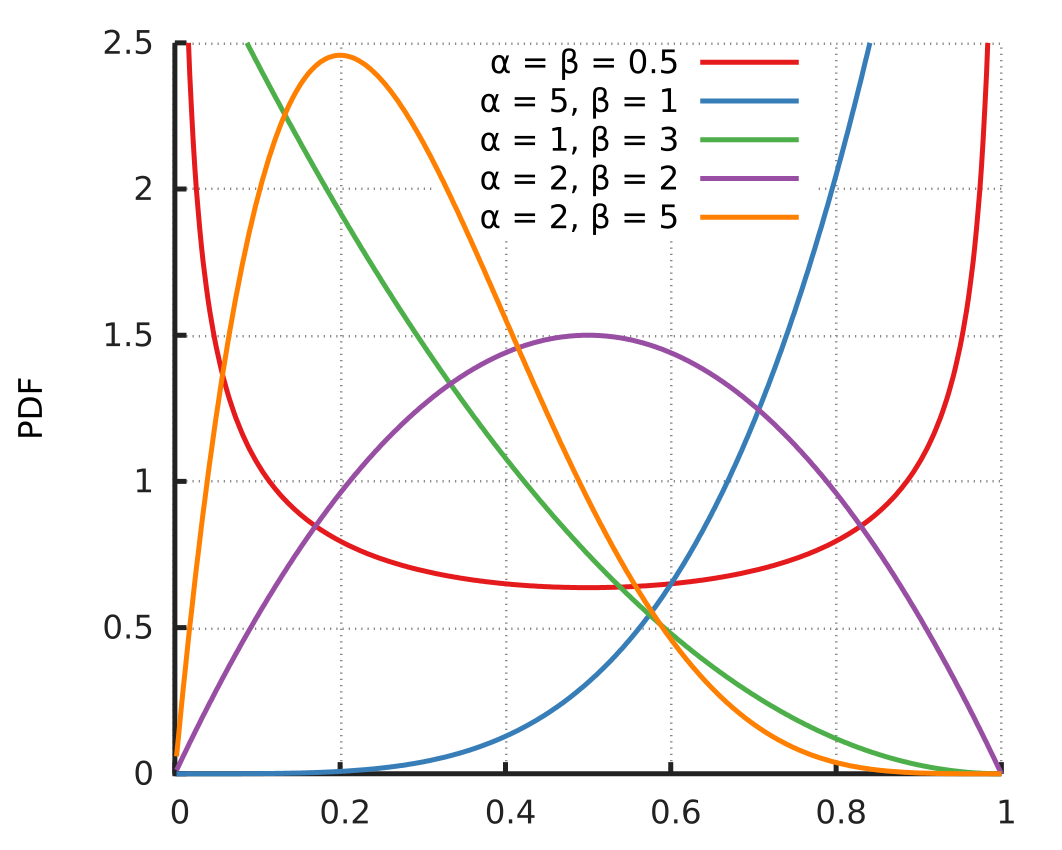

In [5]:
Image(filename='beta.png', width=500)

Photo Cred: https://en.wikipedia.org/wiki/Beta_distribution

The next assumption we make is in regards to the negative likelihood ratio of the CA-19-9 test. In the manuscript, the nLR is derived from a range of sensitivity/specificity of 0.70-0.92. An average is taken (0.8) to derive a nLR of 0.25. In this case, since we are provided a range of sensitivity and specificity, we can bake it in right into the model as can be seen below. We can then compute the nLR in the model from these distribution (which we have modeled with a uniform distribution from 0.70 - 0.92).

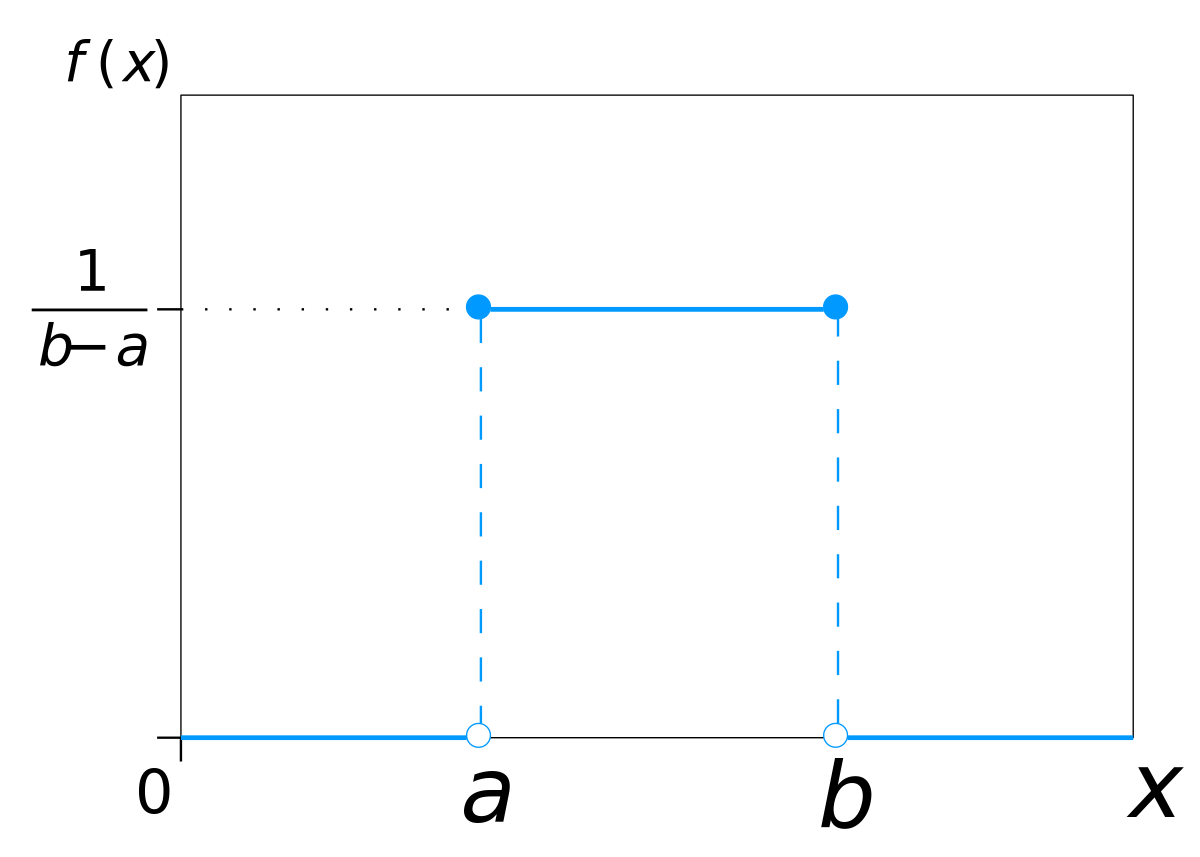

In [6]:
Image(filename='uniform.png', width=500)

Photo Cred: https://en.wikipedia.org/wiki/Continuous_uniform_distribution

Our final assumption in this model we will make is the nLR of the FNA biopsy. Since we are only given a point estimate of the LR, for simplicity, we will model it as a constant variable and will assume there is little uncertainty of the nLR of an FNA biopsy for the purpose of this exercise.

In [9]:
def build_model():
    certainty = 1
    alpha = 9 * certainty
    beta = 1 * certainty
    mean_prior = alpha / (alpha + beta) # mean of prior belief
    var_prior = (alpha * beta) / (np.power(alpha + beta, 2) * (alpha + beta + 1)) # variance of prior belief

    with pm.Model() as model:
        #pre_test prob 1
        "assuming beta prior with a mean of 0.90"
        p_1 = pm.Beta('p_1',alpha=alpha,beta=beta)

        "assuming uninformed prior belief"
        #p_1 = pm.Uniform('p_1')

        o_1 = pm.Deterministic('o_1',(p_1/(1-p_1)))
        sens_ca19_9 = pm.Uniform('sens_ca19_9',lower=0.70,upper=0.92) #range of sensitivity/specificity provided
        l_ca19_9 = pm.Deterministic('l_ca19_9',(1-sens_ca19_9)/sens_ca19_9) # nLR of CA-19-9 test

        #prob after CA-19-9
        o_2 = pm.Deterministic('o_2',o_1*l_ca19_9) #Applying Bayes Rule
        p_2 = pm.Deterministic('p_2',o_2/(o_2+1))

        #prob after FNA
        l_fna = 0.11 #nLR of FNA
        o_3 = pm.Deterministic('o_3',o_2*l_fna) #Applying Bayes Rule
        p_3 = pm.Deterministic('p_3',o_3/(o_3+1))
        pm.model_to_graphviz(model).render("model", format="png")
        return model

Let's first build and view the model.

In [10]:
model = build_model()

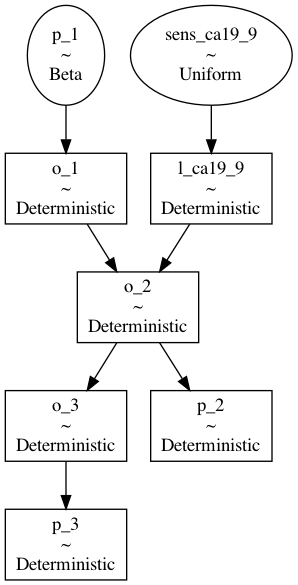

In [12]:
Image(filename='model.png', width=250)

With our model built, we can run it and view its outputs.

In [13]:
model_trace = pm.sample(model=model,cores=1,chains=1,draws=10000)


/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sens_ca19_9, p_1]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


First, we will look at the distribution of our prior belief, the distribution of our likelihood ratio, and the posterior distribution after the CA-19-9 test. Below, we want to focus on the left panels. P_1 represents the beta distribution of our prior belief centered with a mean of 0.90. Below that we see our sampled distribution of our nLR. And below that we can see the distribution of our belief that this is pancreatic cancer after the CA-19-9 test. While the probabibility is still rather high, it is now lower in light of the new evidence we have received.

/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'p_1'}>,
        <AxesSubplot:title={'center':'p_1'}>],
       [<AxesSubplot:title={'center':'l_ca19_9'}>,
        <AxesSubplot:title={'center':'l_ca19_9'}>],
       [<AxesSubplot:title={'center':'p_2'}>,
        <AxesSubplot:title={'center':'p_2'}>]], dtype=object)

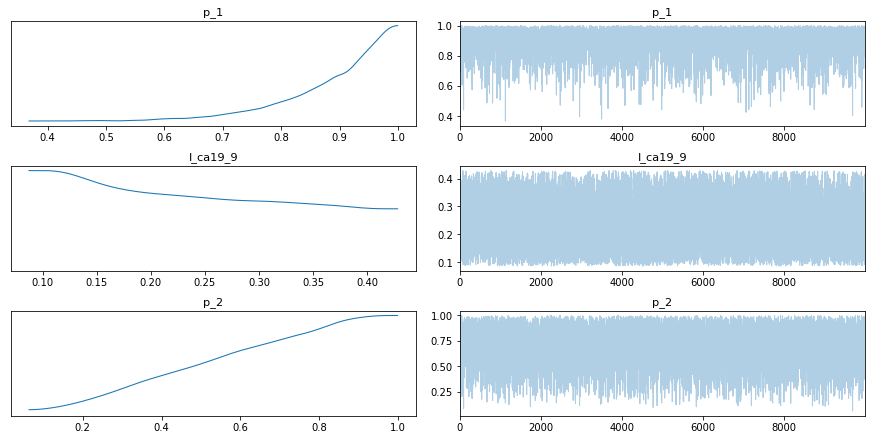

In [14]:
az.plot_trace(model_trace,var_names=['p_1','l_ca19_9','p_2'])

We can now look at the probability distributions at all three steps. We have not included the nLR of the FNA biopsy because it is a constant. We can see below that after these two diagnostic steps, our final posterior probability distribution is quite different from where we started. However, when we look at the 95% range of our data, we note that there is still a non-insignificant probability that this is still pancreatic cancer. 

/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'p_1'}>,
        <AxesSubplot:title={'center':'p_1'}>],
       [<AxesSubplot:title={'center':'p_2'}>,
        <AxesSubplot:title={'center':'p_2'}>],
       [<AxesSubplot:title={'center':'p_3'}>,
        <AxesSubplot:title={'center':'p_3'}>]], dtype=object)

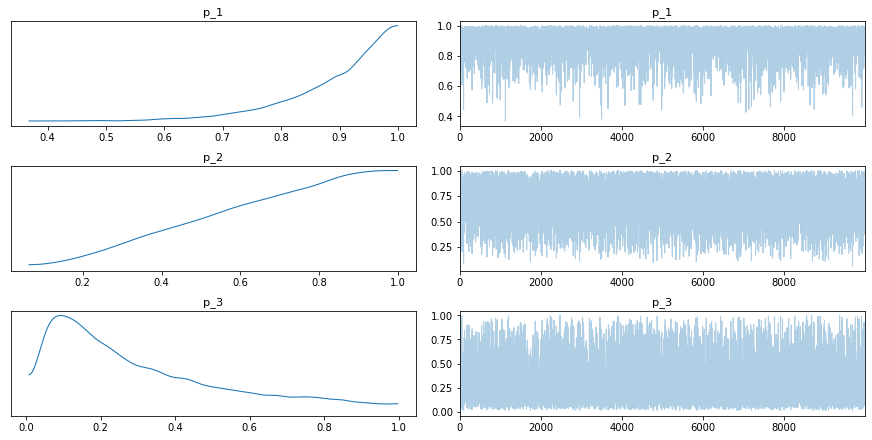

In [15]:
az.plot_trace(model_trace,var_names=['p_1','p_2','p_3'])

In [18]:
np.round(np.percentile(model_trace['p_3'],97.5),2)

0.39